In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !pip install fastai==1.0.61
# !pip install torch==1.4.0
# !pip install torchvision==0.5.0

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate


In [4]:
bs = 64

In [5]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False, verbose=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_158.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_185.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_35.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_74.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_92.jpg')]

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

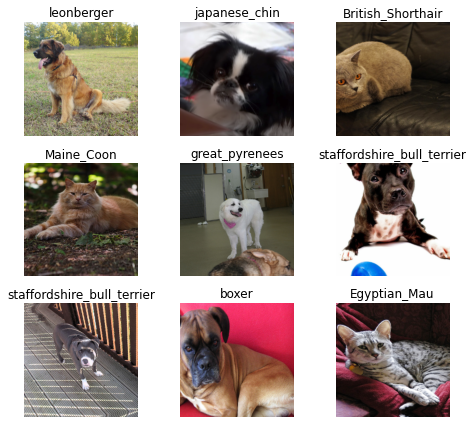

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

### Custom model Pytorch


In [14]:
from torchvision.models import *
model = models.resnet34(pretrained=True).cuda()
for param in model.parameters():
    param.requires_grad=False
model.fc = nn.Sequential(
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
    nn.Linear(256,128),
    nn.ReLU(inplace=True),
    nn.Dropout2d(p=0.3),
    nn.Linear(128,37)).cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [15]:
# model

In [16]:
learn = Learner(data,model,metrics=error_rate)

In [86]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [17]:
learn.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
learn.summary()

ResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        False     
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        False     
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
_______________________________________________________

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.755211,0.491715,0.153586,01:26
1,0.778948,0.306761,0.094723,01:24
2,0.470957,0.258038,0.089310,01:22
3,0.326995,0.216760,0.073748,01:20


In [21]:
torch.save(learn.model.state_dict(),'/content/weight_exp.pth')

In [ ]:
# learn.save('/content/stage-1')

## Results

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

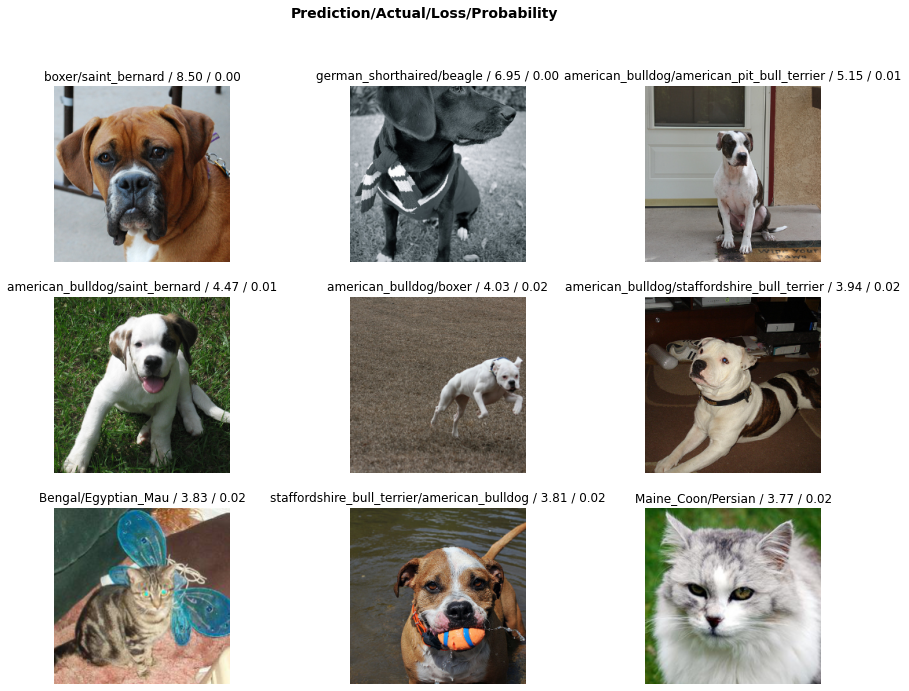

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [24]:
doc(interp.plot_top_losses)

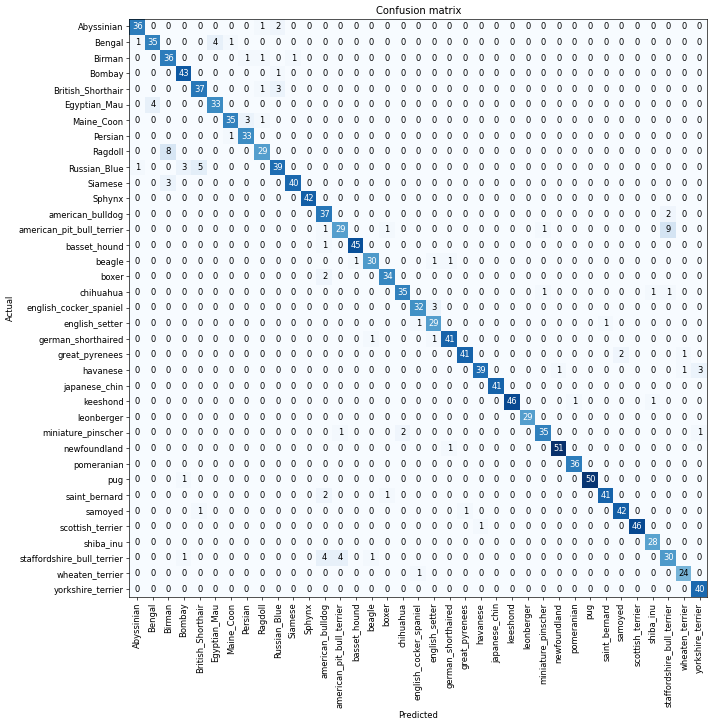

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### ONNX

In [33]:
# !pip install onnxruntime==1.12.1
# !pip install onnx==1.12.0

In [34]:
from torch.autograd import Variable
import io
import numpy as np
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import torchvision
import torch

In [35]:
# Input to the model
x = torch.randn(1,3, 224,224, requires_grad=False).cuda()
torch_out = fmodel(x);

In [36]:
# Export the model
torch.onnx.export(fmodel,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "custom_model_pytorch_v9.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  )

In [38]:
import onnx
onnx_model = onnx.load("/content/custom_model_pytorch_v9.onnx")
onnx.checker.check_model(onnx_model)

In [40]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("/content/custom_model_pytorch_v9.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs[0])
# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

[[-0.535008 -1.022832 -1.446887  2.311676  0.97342  -2.266706  0.289931 -1.189992  0.145878  1.326781 -0.858909
   0.884262 -1.151315 -1.604321 -2.076533 -1.213632 -2.178234 -1.281083 -0.868033 -3.39202  -1.624162 -3.938128
  -1.555882 -2.99197  -3.939738 -4.465491 -1.156863 -1.117255 -2.704084 -3.206006 -3.460686 -2.492036 -0.020428
  -2.243359 -1.118164 -1.565067 -1.218897]]
Exported model has been tested with ONNXRuntime, and the result looks good!


## Pytorch Custom inf

In [26]:
from torchvision import models 

In [27]:
model = models.resnet34(pretrained=False).cuda()
model.fc = nn.Sequential(
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
    nn.Linear(256,128),
    nn.ReLU(inplace=True),
    nn.Dropout2d(p=0.3),
    nn.Linear(128,37)).cuda()

In [30]:
model.load_state_dict(torch.load('/content/weight_exp.pth'))

<All keys matched successfully>

In [31]:
fmodel = model.eval()